<a name=''></a>

---

**Sections:**  ●  [LINK](#link)  ●  [LINK](#link)  ●  [LINK](#link)  ●  [LINK](#link)  ●  [LINK](#link)   ●  [LINK](#link)   ●  [LINK](#link)   ●  [LINK](#link)   ●  [LINK](#link)   ●  [LINK](#link)   ●  [LINK](#link)   ●  [LINK](#link)   ●  [LINK](#link)   ●  [LINK](#link)

---


<a name="top"></a>

# **Neural Network**
## **Sentiment Analysis & Stock Prediction - Part One** 

### [[Udemy]](https://www.udemy.com/course/neural-networks-for-stock-price-prediction-and-sentiment/)
<br>
<font size = 5>

| [Link](link)  |  [Link](link) | </font>

<br>


|<font size = 6>Contents:</font>|   |   |   |
|---|---|---|---|
|<font size = 4>
|[LINK](#link) |  |  [LINK](#link)  |   |
|[LINK](#link)  |  |  [LINK](#link)  |   |
|[LINK](#link)  |  |  [LINK](#link)  |   |
|[LINK](#link) |  |  [LINK](#link)  |   |
|[LINK](#link)  |  |  [LINK](#link)  |   |
|[LINK](#link)  |  |  [LINK](#link)  |   |

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense, Dropout
import os
from helpers import *
from importlib import reload
%matplotlib inline

2023-01-18 23:16:05.518140: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


<a name=''></a>

---

**Sections:**  ●  [LINK](#link)  ●  [LINK](#link)  ●  [LINK](#link)  ●  [LINK](#link)  ●  [LINK](#link)   ●  [LINK](#link)   ●  [LINK](#link)   ●  [LINK](#link)   ●  [LINK](#link)   ●  [LINK](#link)   ●  [LINK](#link)   ●  [LINK](#link)   ●  [LINK](#link)   ●  [LINK](#link)

---

<span style = 'background-color: purple; padding: 5px 5px 3px 5px; line-height: 1.5; color:white;border-radius: 3px;'><font size = 4>Apple Data</font></span>

In [2]:
aapl = pd.read_csv("AAPL.csv").open

In [3]:
head_tail_horz(aapl, 5, "Apple Data")

,open
0,67.71
1,68.07
2,68.50
3,66.74
4,66.36
,open
1254,167.16
1255,166.00
1256,159.10
1257,154.83


<font size = 4><span style = 'background-color: #ddddff; padding: 5px 5px 3px 5px; line-height: 1.5; color:black;border-radius: 3px;'>Converting to numpy array

In [4]:
aapl_np = aapl.values

<font size = 4><span style = 'background-color: #ddddff; padding: 5px 5px 3px 5px; line-height: 1.5; color:black;border-radius: 3px;'>Reshaping for neural network
* converting from (1259,) to (1259, 1)

In [5]:
aapl_np = aapl_np.reshape(-1, 1)
print("shape: ", aapl_np.shape); sp()

aapl_np

shape:  (1259, 1)



array([[ 67.7142],
       [ 68.0714],
       [ 68.5014],
       ...,
       [159.1   ],
       [154.83  ],
       [163.085 ]])

<font size = 4><span style = 'background-color: #ddddff; padding: 5px 5px 3px 5px; line-height: 1.5; color:black;border-radius: 3px;'>Train-Test Split
* 80% train
* 20% test
* 50 overlap - will give first 50 entries for prediction
* last 50 days of value to predict the 51st day

In [6]:
aapl_train = np.array(aapl_np[:int(aapl_np.shape[0]*0.8)])
aapl_test = np.array(aapl_np[int(aapl_np.shape[0]*0.8)-50:])

In [7]:
d(aapl_train.shape)
d(aapl_test.shape)

(1007, 1)

(302, 1)

<font size = 4><span style = 'background-color: #ddddff; padding: 5px 5px 3px 5px; line-height: 1.5; color:black;border-radius: 3px;'>Scaling Training Set
* Values scaled 0-1
* fitting the training data and transforming/scaling

In [8]:
scaler = MinMaxScaler(feature_range=(0, 1))

In [9]:
aapl_train = scaler.fit_transform(aapl_train)
aapl_train

array([[0.15550899],
       [0.16002875],
       [0.16546966],
       ...,
       [0.9222455 ],
       [0.93262121],
       [0.95046235]])

<font size = 4><span style = 'background-color: #ddddff; padding: 5px 5px 3px 5px; line-height: 1.5; color:black;border-radius: 3px;'>Scaling Test Set
* only transforming to match the same scaling as training set

In [10]:
aapl_test = scaler.transform(aapl_test)
aapl_test[0:6]

array([[0.7048619 ],
       [0.70865789],
       [0.70043325],
       [0.71080895],
       [0.69518213],
       [0.68006144]])

<font size = 4><span style = 'background-color: #ddddff; padding: 5px 5px 3px 5px; line-height: 1.5; color:black;border-radius: 3px;'>Creating Dataset
* creating a structure that allows to feed the data into neural network
* batches of 50 values to predict the 51st
* imagine a slider the size of 50 values moving across the data one value at a time
* each time it moves to the next value, it predicts the 51st value again, the next value
* `data.shape[0]` refers to the full length of the dataset
* each target is the value following the 50 inputs before it

In [11]:
def nn_data_prep(data):
	inputs = []
	targets = []
	for item in range(50, data.shape[0]):
		inputs.append(data[item - 50: item, 0])
		targets.append(data[item, 0])
	inputs = np.array(inputs)
	targets = np.array(targets)
	
	return inputs, targets

<font size = 4><span style = 'background-color: #ddddff; padding: 5px 5px 3px 5px; line-height: 1.5; color:black;border-radius: 3px;'>Training and Testing Sets

In [12]:
x_train, y_train = nn_data_prep(aapl_train)
x_test, y_test = nn_data_prep(aapl_test)

In [13]:
x_train[:1].shape, x_test[:1].shape

((1, 50), (1, 50))

<font size = 4><span style = 'background-color: #ddddff; padding: 5px 5px 3px 5px; line-height: 1.5; color:black;border-radius: 3px;'>Reshaping the data
* Adding another dimension 

In [14]:
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

<font size = 4><span style = 'background-color: #ddddff; padding: 5px 5px 3px 5px; line-height: 1.5; color:black;border-radius: 3px;'>Constructing Neural Network Model
* `units` = layers in the neural network
* `return_sequences = True` - the output sent to the next layer
* `input_shape = (x_train.shape[1], 1)` - `x_train.shape[1]` = 50, time steps
	* 1 feature - opening price
* `Dropout` = 20%
* `model.add(Dense(units = 1))` - the prediction


In [15]:
model = Sequential()

model.add(LSTM(units = 96, return_sequences = True,
			   input_shape = (x_train.shape[1], 1)))

model.add(Dropout(0.2))
model.add(LSTM(units = 96, return_sequences = True))
		  
model.add(Dropout(0.2))
model.add(LSTM(units = 96))

model.add(Dropout(0.2))
model.add(Dense(units = 1))

2023-01-18 23:16:08.153636: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


<font size = 4><span style = 'background-color: #ddddff; padding: 5px 5px 3px 5px; line-height: 1.5; color:black;border-radius: 3px;'>Model Summary

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50, 96)            37632     
                                                                 
 dropout (Dropout)           (None, 50, 96)            0         
                                                                 
 lstm_1 (LSTM)               (None, 50, 96)            74112     
                                                                 
 dropout_1 (Dropout)         (None, 50, 96)            0         
                                                                 
 lstm_2 (LSTM)               (None, 96)                74112     
                                                                 
 dropout_2 (Dropout)         (None, 96)                0         
                                                                 
 dense (Dense)               (None, 1)                 9

<font size = 4><span style = 'background-color: #ddddff; padding: 5px 5px 3px 5px; line-height: 1.5; color:black;border-radius: 3px;'>Define loss function and optimizer

In [17]:
model.compile(loss = 'mean_squared_error', 
			  optimizer = "adam")

<font size = 4><span style = 'background-color: #ddddff; padding: 5px 5px 3px 5px; line-height: 1.5; color:black;border-radius: 3px;'>Fitting the model

In [18]:
# if (not os.path.exists(r'/Users/evancarr/Library/CloudStorage/OneDrive-Personal/Code/udemy_nn_stock/stock_prediction_model.h5')):

# model.fit(x_train, y_train, epochs = 50, batch_size=32, verbose = 1)

<font size = 4><span style = 'background-color: #ddddff; padding: 5px 5px 3px 5px; line-height: 1.5; color:black;border-radius: 3px;'>Saving the trained model

In [19]:
# model.save("stock_prediction_nn_model.h5")

<font size = 4><span style = 'background-color: #ddddff; padding: 5px 5px 3px 5px; line-height: 1.5; color:black;border-radius: 3px;'>Loading the trained model

In [20]:
model = load_model("stock_prediction_nn_model.h5")

<font size = 4><span style = 'background-color: #ddddff; padding: 5px 5px 3px 5px; line-height: 1.5; color:black;border-radius: 3px;'>Making predictions

In [21]:
predictions = model.predict(x_test)

8/8 [==============================] - 1s 22ms/step


<font size = 4><span style = 'background-color: #ddddff; padding: 5px 5px 3px 5px; line-height: 1.5; color:black;border-radius: 3px;'>Unscale the predictions

In [22]:
predictions = scaler.inverse_transform(predictions)
predictions[0:6]

array([[124.68587],
       [125.86398],
       [126.74756],
       [127.3911 ],
       [127.86211],
       [128.20259]], dtype=float32)

<font size = 4><span style = 'background-color: #ddddff; padding: 5px 5px 3px 5px; line-height: 1.5; color:black;border-radius: 3px;'>Visualizing Predictions vs Training Data

range(1007, 1259)


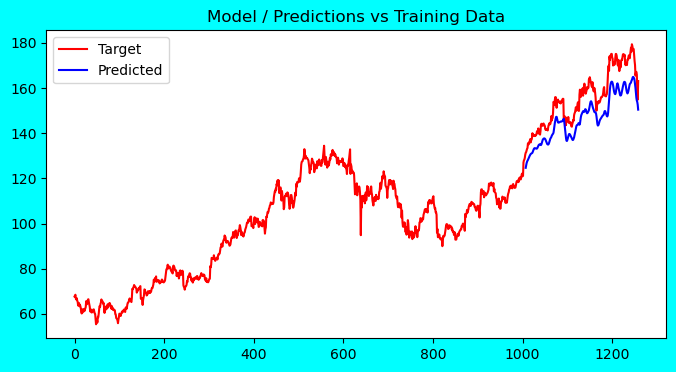

In [23]:
fig, ax = plt.subplots(figsize=(8,4), facecolor = "cyan")
plt.plot(aapl, color='red', label='Target');
ax.plot(range(len(y_train)+50, len(y_train)+50+len(predictions)),predictions,color='blue', label='Predicted');
plt.title("Model / Predictions vs Training Data")
plt.legend()
print(range(len(y_train)+50, len(y_train)+50+len(predictions)))

<font size = 4><span style = 'background-color: #ddddff; padding: 5px 5px 3px 5px; line-height: 1.5; color:black;border-radius: 3px;'>Visualizing Predictions vs Testing Data

In [24]:
y_test_scaled = scaler.inverse_transform(y_test.reshape(-1,1))

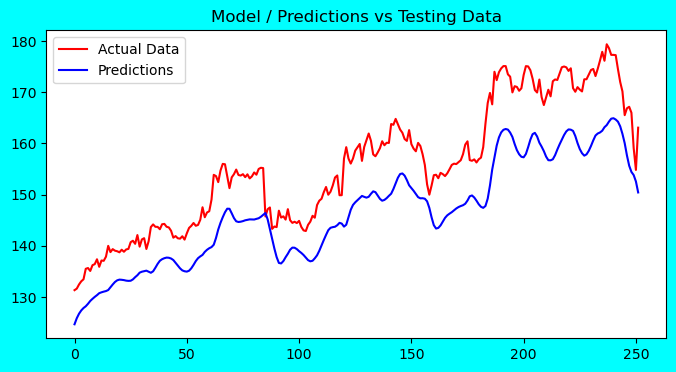

In [25]:
fig, ax = plt.subplots(figsize=(8,4), facecolor = "cyan")
ax.plot(y_test_scaled, color='red', label = 'Actual Data')
plt.plot(predictions, color = 'blue', label='Predictions')
plt.title("Model / Predictions vs Testing Data")
plt.legend()

<font size = 4><span style = 'background-color: #ddddff; padding: 5px 5px 3px 5px; line-height: 1.5; color:black;border-radius: 3px;'>Text

<font size = 4><span style = 'background-color: #ddddff; padding: 5px 5px 3px 5px; line-height: 1.5; color:black;border-radius: 3px;'>Text

<a name=''></a>

---

**Sections:**  ●  [LINK](#link)  ●  [LINK](#link)  ●  [LINK](#link)  ●  [LINK](#link)  ●  [LINK](#link)   ●  [LINK](#link)   ●  [LINK](#link)   ●  [LINK](#link)   ●  [LINK](#link)   ●  [LINK](#link)   ●  [LINK](#link)   ●  [LINK](#link)   ●  [LINK](#link)   ●  [LINK](#link)

---

<span style = 'background-color: purple; padding: 5px 5px 3px 5px; line-height: 1.5; color:white;border-radius: 3px;'><font size = 4>label</font></span>

<font size = 4><span style = 'background-color: #ddddff; padding: 5px 5px 3px 5px; line-height: 1.5; color:black;border-radius: 3px;'>Text

<font size = 4><span style = 'background-color: #ddddff; padding: 5px 5px 3px 5px; line-height: 1.5; color:black;border-radius: 3px;'>Text

<font size = 4><span style = 'background-color: #ddddff; padding: 5px 5px 3px 5px; line-height: 1.5; color:black;border-radius: 3px;'>Text

<font size = 4><span style = 'background-color: #ddddff; padding: 5px 5px 3px 5px; line-height: 1.5; color:black;border-radius: 3px;'>Text

<font size = 4><span style = 'background-color: #ddddff; padding: 5px 5px 3px 5px; line-height: 1.5; color:black;border-radius: 3px;'>Text

<font size = 4><span style = 'background-color: #ddddff; padding: 5px 5px 3px 5px; line-height: 1.5; color:black;border-radius: 3px;'>Text

<font size = 4><span style = 'background-color: #ddddff; padding: 5px 5px 3px 5px; line-height: 1.5; color:black;border-radius: 3px;'>Text

<a name=''></a>

---

**Sections:**  ●  [LINK](#link)  ●  [LINK](#link)  ●  [LINK](#link)  ●  [LINK](#link)  ●  [LINK](#link)   ●  [LINK](#link)   ●  [LINK](#link)   ●  [LINK](#link)   ●  [LINK](#link)   ●  [LINK](#link)   ●  [LINK](#link)   ●  [LINK](#link)   ●  [LINK](#link)   ●  [LINK](#link)

---

<span style = 'background-color: purple; padding: 5px 5px 3px 5px; line-height: 1.5; color:white;border-radius: 3px;'><font size = 4>label</font></span>

In [26]:
import_all()

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/Users/evancarr/opt/anaconda3/envs/udemy_nn_stock/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3433, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/var/folders/wx/x69ggs7s5cgd2gw98rpcp8bm0000gn/T/ipykernel_38656/2579220818.py", line 1, in <module>
    import_all()
  File "/Users/evancarr/Library/CloudStorage/OneDrive-Personal/Code/udemy_nn_stock/helpers.py", line 49, in import_all
    yf_import()
  File "/Users/evancarr/Library/CloudStorage/OneDrive-Personal/Code/udemy_nn_stock/helpers.py", line 44, in yf_import
    yf = __import__('yfinance', globals(), locals())
ModuleNotFoundError: No module named 'yfinance'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/evancarr/opt/anaconda3/envs/udemy_nn_stock/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 2052, in showtraceback
    stb = self.InteractiveTB.st

<font size = 4><span style = 'background-color: #ddddff; padding: 5px 5px 3px 5px; line-height: 1.5; color:black;border-radius: 3px;'>Text

<font size = 4><span style = 'background-color: #ddddff; padding: 5px 5px 3px 5px; line-height: 1.5; color:black;border-radius: 3px;'>Text

<font size = 4><span style = 'background-color: #ddddff; padding: 5px 5px 3px 5px; line-height: 1.5; color:black;border-radius: 3px;'>Text

<font size = 4><span style = 'background-color: #ddddff; padding: 5px 5px 3px 5px; line-height: 1.5; color:black;border-radius: 3px;'>Text

<font size = 4><span style = 'background-color: #ddddff; padding: 5px 5px 3px 5px; line-height: 1.5; color:black;border-radius: 3px;'>Text

<font size = 4><span style = 'background-color: #ddddff; padding: 5px 5px 3px 5px; line-height: 1.5; color:black;border-radius: 3px;'>Text

<font size = 4><span style = 'background-color: #ddddff; padding: 5px 5px 3px 5px; line-height: 1.5; color:black;border-radius: 3px;'>Text